In [ ]:
!wget 'https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip'
!unzip '/content/caltech-101.zip'
!tar -xf '/content/caltech-101/101_ObjectCategories.tar.gz'

In [ ]:
#Приводим изображение к "стандартному размеру"
def resize(tensor, h = 256, w = 256):
  return cv2.resize(tensor, [h, w], interpolation = cv2.INTER_CUBIC)
path = '/content/101_ObjectCategories'

# Все изображения сохранены в отдельных каталогах "Название каталога(категория изображения)/img1"
# Расайзнем, переименнуем(в имени изображения содержится категория) и сохраним изображения в отдельный каталог

def reorcan_set_in_random_Set(path):
  list_dir = os.listdir(path)

  for i in list_dir:
    list_img = os.listdir(os.path.join(path, i))

    for j in list_img:
      img_patch = os.path.join(path, i, j)
      img_list = img_patch.split('/')
      if '.jpg' in img_patch:
        img = cv2.imread(img_patch)
        tensor = resize(img)
        cv2.imwrite('/content/Image/' + '_'.join(img_list[3:]) , tensor)
        
reorcan_set_in_random_Set(path)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors 
import os
import cv2

In [ ]:
# Загрузим эмбединги
embedings = pd.read_csv('/content/drive/MyDrive/Ml_task/Same_img/image_emdeding.csv')

In [ ]:
embedings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9144 entries, 0 to 9143
Columns: 513 entries, Unnamed: 0 to 511
dtypes: float64(512), object(1)
memory usage: 35.8+ MB


In [ ]:
embedings.shape

(9144, 513)

In [ ]:
embedings.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,pagoda_image_0017,0.778435,0.516871,1.732729,0.570153,1.026246,0.716339,1.012143,0.043743,1.348302,...,0.700810,1.020896,0.137339,0.994922,0.434318,0.917238,1.595193,0.414039,0.208611,0.200643
1,gramophone_image_0013,0.056121,0.980566,0.369768,0.434372,1.769724,0.110120,1.143919,2.639035,0.888779,...,0.808675,0.097510,0.667324,0.301454,0.493072,1.385418,0.600500,0.444145,0.340821,0.559871
2,ferry_image_0017,0.393111,1.154630,1.472480,1.026809,1.064146,0.218376,0.143240,3.100277,0.120186,...,0.078548,0.134827,0.083210,1.779563,0.486809,0.207124,0.463311,0.729826,3.259856,0.297687
3,helicopter_image_0005,0.253704,1.890817,0.512636,0.106184,0.646727,0.399334,0.484600,1.408884,0.020561,...,0.424655,0.419725,0.084015,0.776263,0.000801,0.367935,0.672924,0.011229,1.806722,0.177449
4,Faces_easy_image_0267,0.832179,0.231744,0.414232,0.644682,0.708726,0.443643,1.465188,0.249275,0.000000,...,0.211916,0.225934,1.223178,0.712111,1.861628,1.570248,0.724001,0.922557,0.444299,1.300376


На прошлом этапе мы получили эмбединги для 9144 изображений с помощью НС ResNet18

Попробуем различные методы поиска ближайших соседей(KNN, HNSV, Kd_Tree), оценим их качество и время работы на CPU
 

In [ ]:
embedings = embedings.set_index('Unnamed: 0')

In [ ]:
def check_accurcy_score(same_image): # Функция получает словарик {'изображение': 'ближайшие соседи'} и проверят сколько раз название класса "изображения" встречается в соседях
  total = 0
  true_neighbors = 0

  for i in same_image:
    
    true_img = i.split('_')[0]
    
    for j in same_image[i]:
      total += 1
      
      if j.split('_')[0] == true_img:
        true_neighbors += 1
  # Выводим Accurcy
  return true_neighbors / total

In [ ]:
#Словарик {имя_изображения : [имена_ближайщих соседей,...,..,]}
indexes = embedings.index
images = {}
def convert_same_img(indexes, lable, images = {}):
  
  for i in range(len(lable)):
    images[indexes[i]] = []
    
    n = len(lable[i])

    for j in range(n):
      
      if indexes[i] == indexes[lable[i][j]]:
        continue

      images[indexes[i]].append(indexes[lable[i][j]])
  
  return images

In [ ]:
path = '/content/Image/'
# Выводим случайно count_picters целевых изображений и 5 ближайших к этому целевому
def show_img(path, images, indexes, count_picters = 4):
  picters = np.random.choice(indexes, count_picters)

  fig, ax = plt.subplots(nrows = count_picters, ncols = 6, figsize = (15, 15))

  for r in range(count_picters):
    
    ax[r,0].imshow(cv2.imread(os.path.join(path + picters[r] + '.jpg')))

    ax[r,1].imshow(cv2.imread(os.path.join(path, images[picters[r]][0] + '.jpg')))
    
    ax[r,2].imshow(cv2.imread(os.path.join(path, images[picters[r]][1] + '.jpg')))
    
    ax[r,3].imshow(cv2.imread(os.path.join(path, images[picters[r]][2] + '.jpg')))
    
    ax[r,4].imshow(cv2.imread(os.path.join(path, images[picters[r]][3] + '.jpg')))
    
    ax[r,5].imshow(cv2.imread(os.path.join(path, images[picters[r]][4] + '.jpg')))


# NearestNeighbors

In [ ]:
brute = NearestNeighbors(n_neighbors = 5, algorithm = 'brute', metric = 'l2') 
kd_tree = NearestNeighbors(n_neighbors = 5, algorithm = 'kd_tree', metric = 'l2')  # Метрика Косинустного расстояния отсутствует в kd_tree

Для того, чтобы посмотреть валидные метрики: sklearn.neighbors.VALID_METRICS ['<нужный алгоритм>']

# BruteForce

In [ ]:
%%time
brute.fit(embedings)

CPU times: user 26 ms, sys: 13.4 ms, total: 39.4 ms
Wall time: 39 ms


NearestNeighbors(algorithm='brute')

In [ ]:
%%time
distance, indicase = brute.kneighbors(n_neighbors = 5)

CPU times: user 5.79 s, sys: 9.14 ms, total: 5.8 s
Wall time: 3.95 s


In [ ]:
images = convert_same_img(indexes, indicase, images = {})
check_accurcy_score(images)

0.8104549431321085

# Kd_Tree

In [ ]:
%%time
kd_tree.fit(embedings)

CPU times: user 847 ms, sys: 13.8 ms, total: 861 ms
Wall time: 884 ms


NearestNeighbors(algorithm='kd_tree', metric='l2')

In [ ]:
%%time
distance, indicase = kd_tree.kneighbors(n_neighbors = 5)

CPU times: user 1min 56s, sys: 78.9 ms, total: 1min 57s
Wall time: 1min 58s


In [ ]:
images = convert_same_img(indexes, indicase, images = {})
check_accurcy_score(images)

0.8104549431321085

# HSNW


In [ ]:
!pip install hnswlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hnswlib: filename=hnswlib-0.7.0-cp310-cp310-linux_x86_64.whl size=2119857 sha256=338378a8b341be0adc1472cd1faceca20294b827c21319aaa8157334992f29f6
  Stored in directory: /root/.cache/pip/wheels/8a/ae/ec/235a682e0041fbaeee389843670581ec6c66872db856dfa9a4
Successfully built hnswlib


 Ссылка на репозиторий с библиотекой: https://pypi.org/project/hnswlib/

In [ ]:
import hnswlib

In [ ]:
%%time
dimention = 512 # Размерность пространства эмбедигов

index = hnswlib.Index(dim = dimention, space = 'l2') # Space - мера близости

index.init_index(max_elements = 10000, M = 16, ef_construction = 200) # M -  кол-во элементов, соединенных с вершиной, ef_construction - кол-во ближайших соседей, на которых мы смотрим

index.add_items(embedings) # Построили HNSW на датасете

CPU times: user 4.83 s, sys: 20.7 ms, total: 4.85 s
Wall time: 3.15 s


In [ ]:
%%time
lable, distanse = index.knn_query(embedings, k = 6)

CPU times: user 583 ms, sys: 1.77 ms, total: 585 ms
Wall time: 318 ms


In [ ]:
set_images = convert_same_img(indexes, lable, images = {})

In [ ]:
check_accurcy_score(set_images)

0.8102988726732501

In [ ]:
dimention = 512 
def chek_best_params(epoch):
  
  for _ in range(epoch):
    space = np.random.choice(['l2', 'ip', 'cosine'])
  
    M = int(np.random.uniform(16,128))

    ef_construction = int(np.random.uniform(200, 1000))

    index = hnswlib.Index(dim = dimention, space = space) 

    index.init_index(max_elements = 10000, M = M, ef_construction = ef_construction)

    index.add_items(embedings)

    lable, distanse = index.knn_query(embedings, k = 6)

    set_images = convert_same_img(indexes, lable, {})

    print(f'accurcy = {check_accurcy_score(set_images)}, space = {space}, M = {M}, ef_construction = {ef_construction}') 

In [ ]:
%%time
chek_best_params(10)

accurcy = 0.8323053368328959, space = cosine, M = 55, ef_construction = 776
accurcy = 0.8324146981627296, space = cosine, M = 29, ef_construction = 890
accurcy = 0.832505850703178, space = cosine, M = 40, ef_construction = 364
accurcy = 0.5829909613804437, space = ip, M = 69, ef_construction = 544
accurcy = 0.8323053368328959, space = cosine, M = 71, ef_construction = 908
accurcy = 0.8323272090988626, space = cosine, M = 78, ef_construction = 598
accurcy = 0.8323709536307962, space = cosine, M = 77, ef_construction = 733
accurcy = 0.8323709536307962, space = cosine, M = 67, ef_construction = 872
accurcy = 0.8322615923009624, space = cosine, M = 120, ef_construction = 798
accurcy = 0.8103746145603254, space = l2, M = 92, ef_construction = 691
CPU times: user 2min 43s, sys: 697 ms, total: 2min 44s
Wall time: 1min 39s


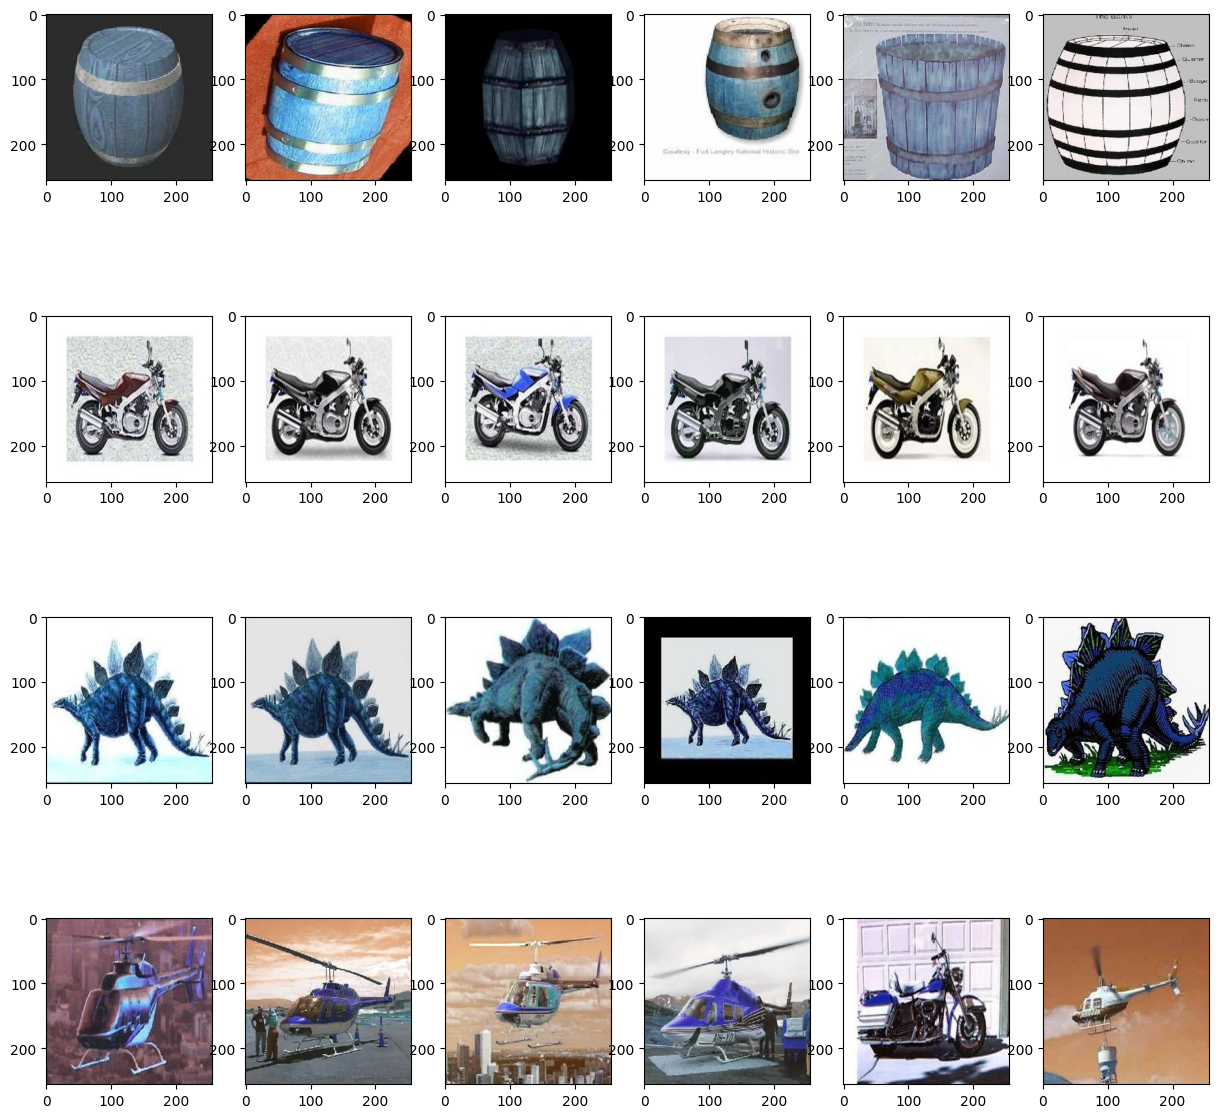

In [ ]:
show_img(path, images, indexes, count_picters = 4)

Видно, что при одинаковых мерах близости алгоритмы выдают практически один и тот же результат точности(отличается в несколько тысячных). При L2 у всех трех алгоритмов точность 81%
Это значит что точность для выбранной меры близости зависит от качества эмбеддингов.
Лучшее качество показала косинусная мера близости - 83%


При этом время работы алгоритмов было такое:


1) BruteForce - 39 ms для вычисления растояни между всеми сэмплами и 5.8 s для того чтобы найти 5 ближайших соседей


2) Kd_Tree - 861 ms для того чтобы построить все деревья и 1m 58s для того чтобы найти 5 ближайших


3) HNSW - 4.85 для того чтобы построить граф и 295 ms для того, чтобы найти 5 ближайших соседей


Из результатов времени работы алгоритмов можно сделать следующий вывод: Алгоритм HNSM показал лучшее соотношение точности и времени поиска k = 5 ближайших соседей
